#Versão final

## 1. IMPORTAR BIBLIOTECAS


In [62]:
!pip install catboost lightgbm

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge

# salva modelos em .pkl
import joblib

# Bibliotecas de modelos posteriores / Sem erro de exec
try:
    from xgboost import XGBRegressor
    xgboost_disponivel = True
except ImportError:
    xgboost_disponivel = False

try:
    from lightgbm import LGBMRegressor
    lightgbm_disponivel = True
except ImportError:
    lightgbm_disponivel = False

try:
    from catboost import CatBoostRegressor
    catboost_disponivel = True
except ImportError:
    catboost_disponivel = False

# Ajustes de visualização
plt.style.use("seaborn-v0_8-whitegrid")

sns.set()
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_palette("Blues_r")
sns.set_style("whitegrid")

plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
})

## 2. FUNÇÕES


In [64]:
def distancia_euclidiana(lat1, lon1, lat2, lon2):
    """Retorna distância euclidiana entre (lat1, lon1) e (lat2, lon2)"""
    return np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)


def remover_outliers_iqr(df, coluna='preco', fator=1.5):
    """
    Remove outliers com base no IQR (faixa interquartil)

    Retorna (df_filtrado, qtd_removidos, pct_removido, (lim_inf, lim_sup))
    """
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1

    lim_inferior = max(1, Q1 - fator * IQR)
    lim_superior = Q3 + fator * IQR

    n_antes = len(df)
    df_filtrado = df[(df[coluna] >= lim_inferior) & (df[coluna] <= lim_superior)]
    n_depois = len(df_filtrado)

    qtd_removidos = n_antes - n_depois
    pct_removido = 100.0 * qtd_removidos / n_antes
    return df_filtrado, qtd_removidos, pct_removido, (lim_inferior, lim_superior)


# Testa se as variaveis adicionais podem gerar alguma acurácia adicional para o modelo em coparação de fazer sem elas
def criar_variaveis_adicionais(df, usar_features=True):
    """
    Se usar_features=True, o algoritmo cria colunas adicionais para treinar o modelo:
          -dist_times_square
          -dist_central_park
    """
    df_copy = df.copy()
    if usar_features and 'latitude' in df_copy.columns and 'longitude' in df_copy.columns:
        lat_ts, lon_ts = 40.758896, -73.985130
        lat_cp, lon_cp = 40.785091, -73.968285

        df_copy['dist_times_square'] = distancia_euclidiana(
            df_copy['latitude'], df_copy['longitude'], lat_ts, lon_ts
        )
        df_copy['dist_central_park'] = distancia_euclidiana(
            df_copy['latitude'], df_copy['longitude'], lat_cp, lon_cp
        )
    return df_copy


def salvar_modelo(modelo, filename="melhor_modelo.pkl"):
    """Salva o modelo em formato .pkl"""
    joblib.dump(modelo, filename)
    print(f"O modelo foi salvo com o seguinte nome:   {filename}")


## 3. análise exploratória dos dados (EDA)

### 3.1 Leitura e EDA inicial

In [65]:
df = pd.read_csv("teste_indicium_precificacao.csv")
print("\n Dimensões iniciais: ")
print(df.shape)
print(df.head())



 Dimensões iniciais: 
(48894, 16)
     id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  minimo_noites  numero_de_reviews ultima_review  \
0  Entire home/apt    225              1                 45    2019-05

In [66]:
print("\nInfo e tipos de dados:")
print(df.info())



Info e tipos de dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review         

In [67]:
print("\nEstatísticas descritivas (numéricas):")
print(df.describe())



Estatísticas descritivas (numéricas):
                 id       host_id      latitude     longitude         price  \
count  4.889400e+04  4.889400e+04  48894.000000  48894.000000  48894.000000   
mean   1.901753e+07  6.762139e+07     40.728951    -73.952169    152.720763   
std    1.098288e+07  7.861118e+07      0.054529      0.046157    240.156625   
min    2.595000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.472371e+06  7.822737e+06     40.690100    -73.983070     69.000000   
50%    1.967743e+07  3.079553e+07     40.723075    -73.955680    106.000000   
75%    2.915225e+07  1.074344e+08     40.763117    -73.936273    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimo_noites  numero_de_reviews  reviews_por_mes  \
count   48894.000000       48894.000000     38842.000000   
mean        7.030085          23.274758         1.373251   
std        20.510741          44.550991         1.680453   
min      

**Preço de hospedagem min = 0 e max = 10000**

Tem algo errado já que a mediana é 106

In [68]:
print("\nEstatísticas descritivas (categóricas):")
display(df.describe(include=['object', 'category']))


Estatísticas descritivas (categóricas):


,nome,host_name,bairro_group,bairro,room_type,ultima_review
count,48878,48873,48894,48894,48894,38842
unique,47904,11452,5,221,3,1764
top,Hillside Hotel,Michael,Manhattan,Williamsburg,Entire home/apt,2019-06-23
freq,18,417,21661,3920,25409,1413


In [69]:
print("\nValores ausentes:")
print(df.isnull().sum())


Valores ausentes:
id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64


**Análise**:
- Observei que faltam dados em `nome`, `host_name`, `ultima_review` e `reviews_por_mes`.
- Se `reviews_por_mes` é nulo, não rebeberam uma avaliação = `0`.
- Remoção da `ultima_review`.

**Hipótese**:  
- Anúncios sem `ultima_review` possivelmente não tiveram hóspedes ou não receberem avaliações recentes. Pode significar imóveis novos ou pouco populares.  

- Ação tomada:  `reviews_por_mes` com 0 onde era nulo


### 3.2 Visualização

#### Visualização do preço

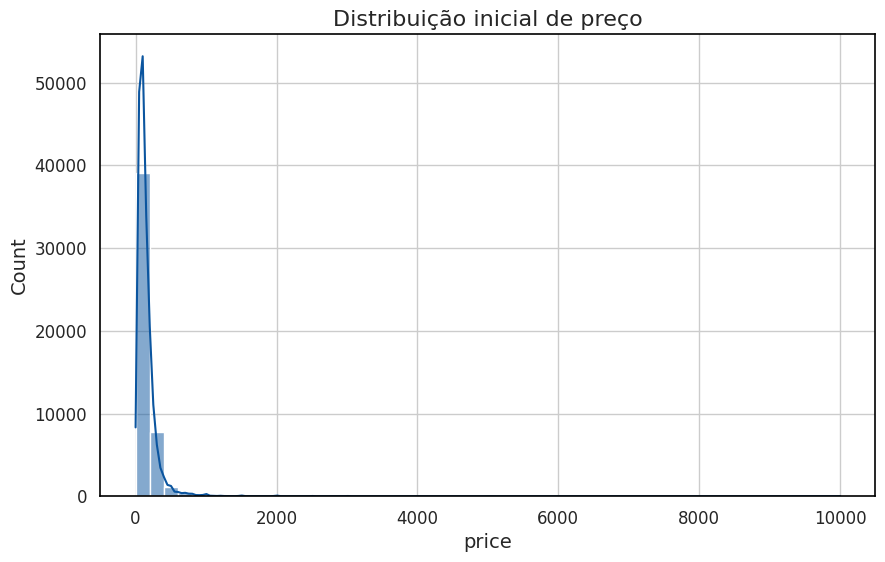

In [70]:
plt.figure()
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Distribuição inicial de preço")
plt.show()


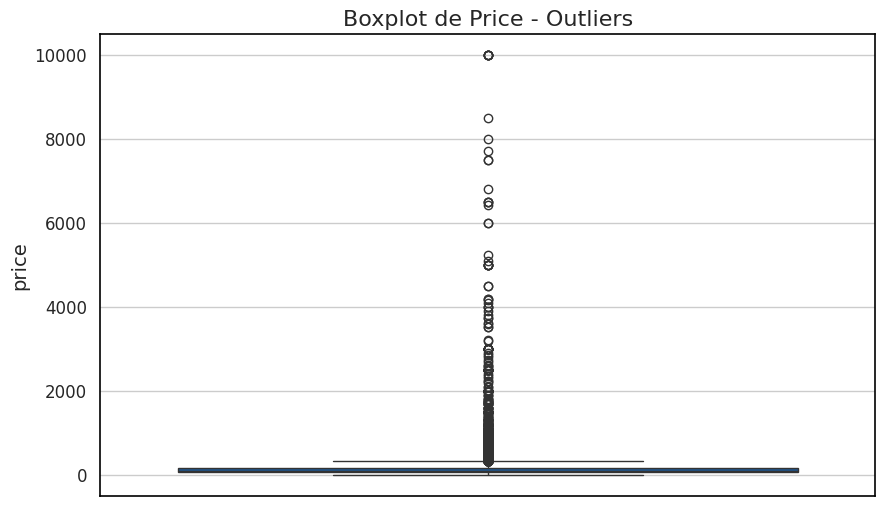

In [71]:
# Boxplot
plt.figure()
sns.boxplot(y=df['price'])
plt.title("Boxplot de Price - Outliers")
plt.show()

In [72]:
# Estatísticas focadas em Price
print("Estatísticas de preço:\n", df['price'].describe())

Estatísticas de preço:
 count    48894.000000
mean       152.720763
std        240.156625
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


**Observações**:

- Existe uma cauda longa na distribuição, isso sugere outliers que podem distorcer o resultado do modelo final.  

**Uso de 'log_price'** no futuro  
- Decidi criar `log_price = log(1+price)` para estabilizar a distribuição e melhorar correlações.

---


#### Agrupamentos

#### Agrupamento por bairros

In [73]:
print("bairro_group - Contagem:")
display(df['bairro_group'].value_counts())
plt.figure()

bairro_group - Contagem:


,count
bairro_group,
Manhattan,21661
Brooklyn,20103
Queens,5666
Bronx,1091
Staten Island,373


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

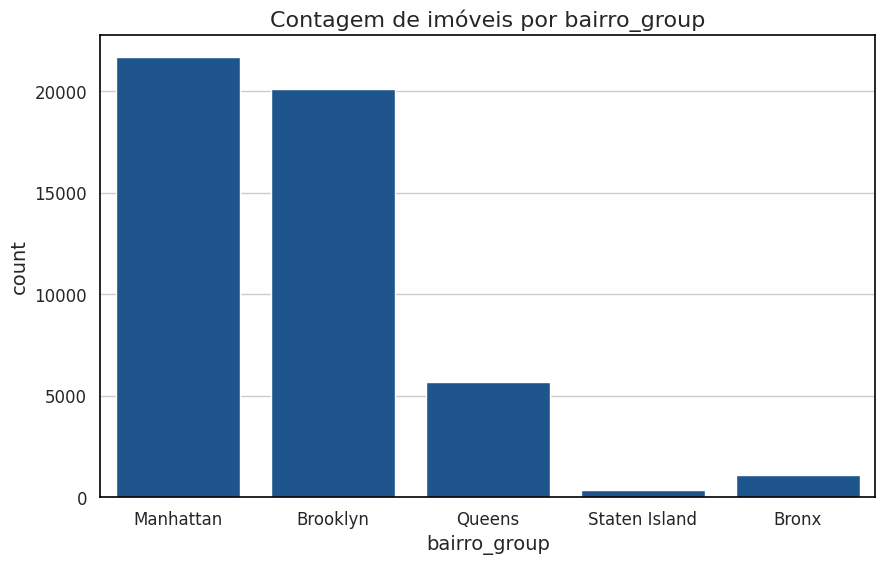

In [74]:
sns.countplot(x='bairro_group', data=df)
plt.title("Contagem de imóveis por bairro_group")
plt.show()


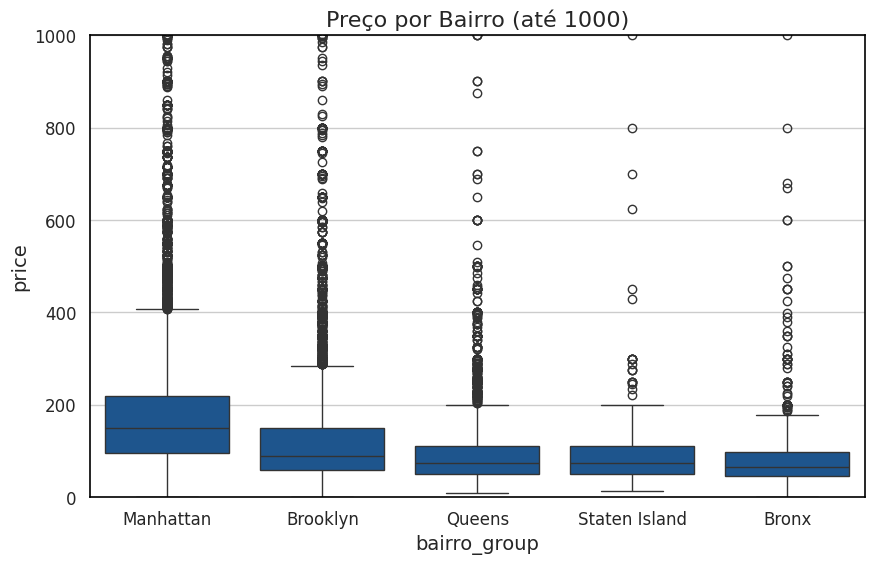

In [75]:
# Boxplot por 'bairro_group'
if 'bairro_group' in df.columns:
    plt.figure()
    sns.boxplot(data=df, x='bairro_group', y='price')
    plt.ylim(0, 1000)
    plt.title("Preço por Bairro (até 1000)")
    plt.show()

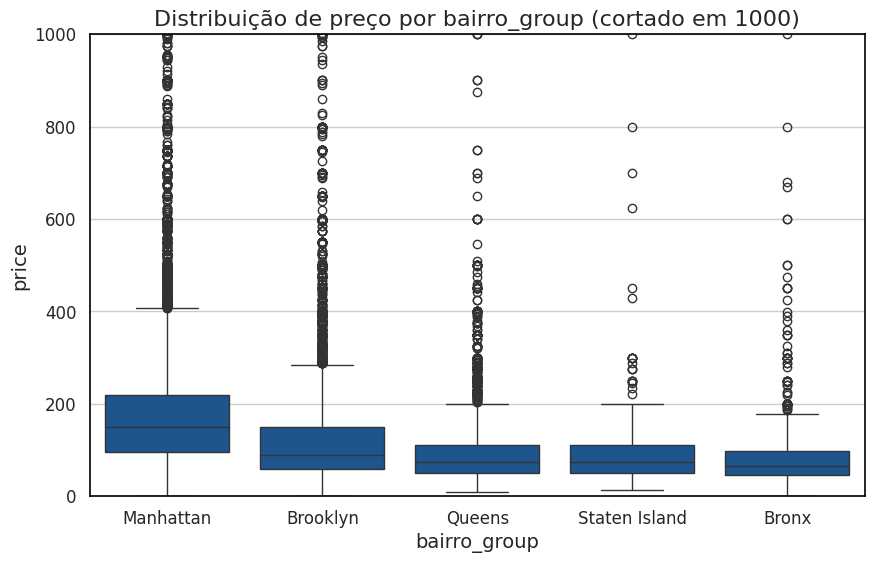

In [76]:
# Price vs. bairro_group
plt.figure()
sns.boxplot(x='bairro_group', y='price', data=df)
plt.ylim(0, 1000)
plt.title("Distribuição de preço por bairro_group (cortado em 1000)")
plt.show()


Análise de Preço por Bairro (Maior para o Menor):
               Média de Preço  Mediana de Preço  Índice Relativo
bairro_group                                                    
Manhattan          196.875814             150.0         1.289123
Brooklyn           124.381983              90.0         0.814441
Staten Island      114.812332              75.0         0.751779
Queens              99.517649              75.0         0.651631
Bronx               87.496792              65.0         0.572920


<Figure size 1000x600 with 0 Axes>

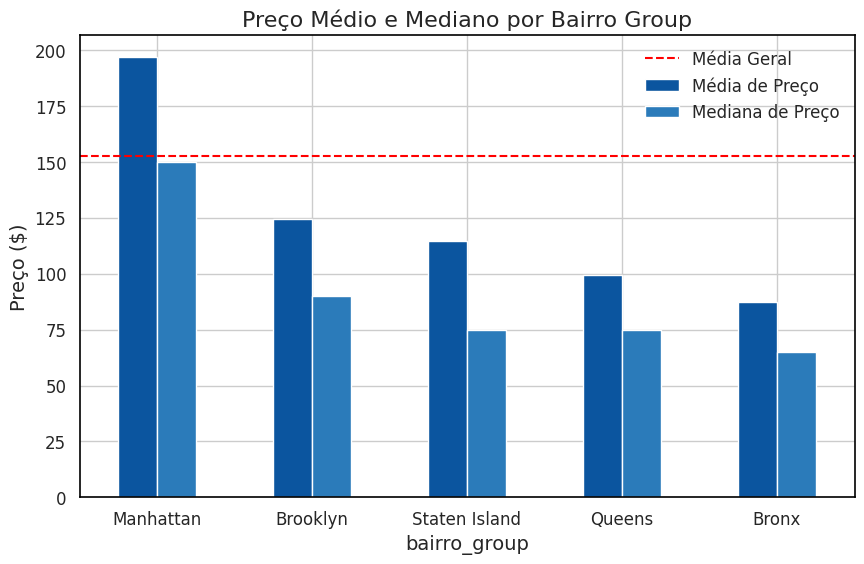

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculando a média e a mediana do preço agrupando por bairro_group
preco_media = df.groupby('bairro_group')['price'].mean().sort_values(ascending=False)
preco_mediana = df.groupby('bairro_group')['price'].median().sort_values(ascending=False)

media_geral = df['price'].mean()

# Criando um índice relativo, (preço médio do bairro comparado com a média da cidade)
indice_relativo = preco_media / media_geral

df_precos = pd.DataFrame({
    'Média de Preço': preco_media,
    'Mediana de Preço': preco_mediana,
    'Índice Relativo': indice_relativo
}).sort_values(by='Média de Preço', ascending=False)

# Exibir os dados ordenados
print("\nAnálise de Preço por Bairro (Maior para o Menor):")
print(df_precos)

# Gráfico do bairro mais caro para o mais barato
plt.figure(figsize=(10, 6))
df_precos[['Média de Preço', 'Mediana de Preço']].plot(kind='bar', figsize=(10,6))
plt.axhline(media_geral, color='red', linestyle='--', label="Média Geral")
plt.title("Preço Médio e Mediano por Bairro Group")
plt.ylabel("Preço ($)")
plt.legend()
plt.xticks(rotation=0)
plt.show()


#### Tipo de quarto

In [78]:
print("\nTipo de Quarto - room_type - Contagem:")
display(df['room_type'].value_counts())
plt.figure()


Tipo de Quarto - room_type - Contagem:


,count
room_type,
Entire home/apt,25409
Private room,22325
Shared room,1160


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

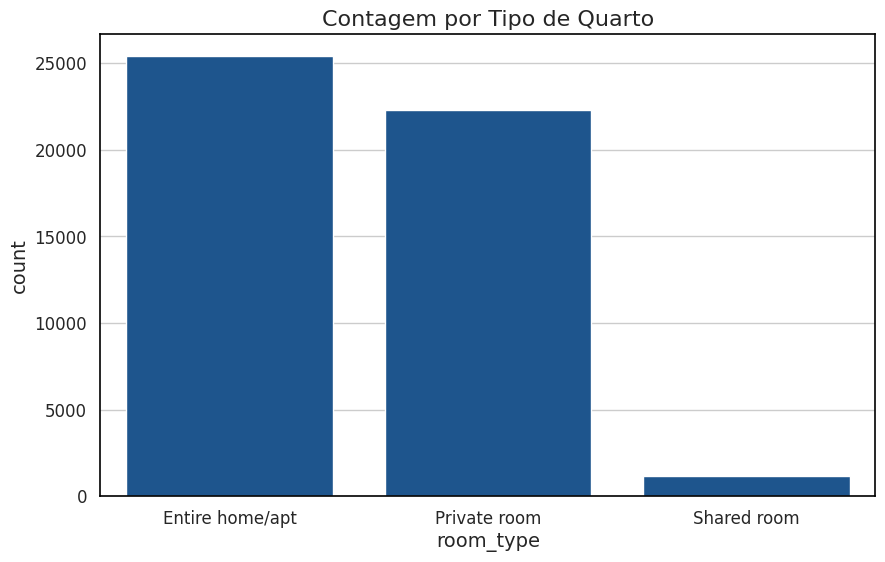

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [79]:
sns.countplot(x='room_type', data=df)
plt.title("Contagem por Tipo de Quarto")
plt.show()
plt.figure()

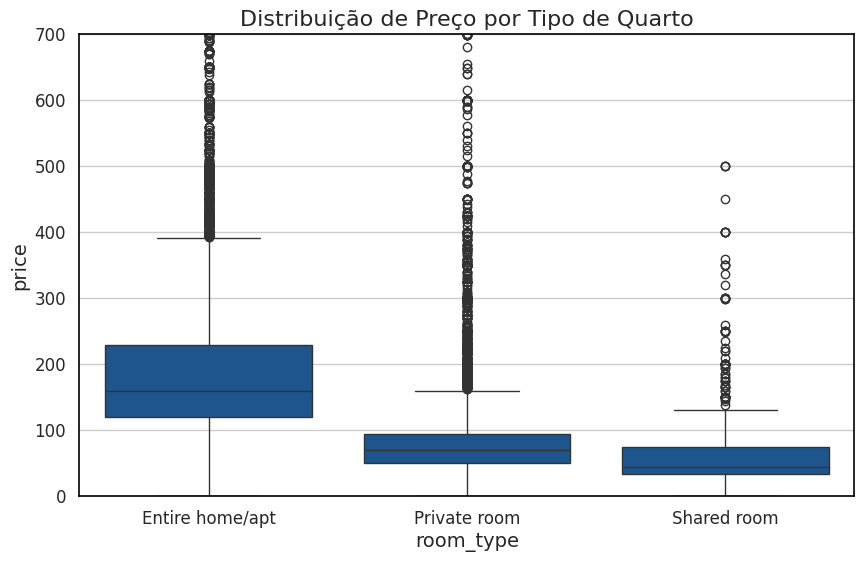

In [80]:
sns.boxplot(x='room_type', y='price', data=df)
plt.ylim(0, 700)
plt.title("Distribuição de Preço por Tipo de Quarto")
plt.show()

** Conclusões**:
1. `Entire home/apt` tende a ter maior mediana de preço.  
2. `Private room` e `Shared room` custam menos, respectivamente

#### Variaveis númericas


Matriz de Correlação


,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,disponibilidade_365
latitude,1.000000,0.084777,0.033939,0.024861,-0.015399,-0.010168,-0.010926
longitude,0.084777,1.000000,-0.150020,-0.062750,0.059092,0.145941,0.082751
price,0.033939,-0.150020,1.000000,0.042799,-0.047954,-0.030608,0.081833
minimo_noites,0.024861,-0.062750,0.042799,1.000000,-0.080118,-0.121708,0.144320
numero_de_reviews,-0.015399,0.059092,-0.047954,-0.080118,1.000000,0.549865,0.172047
reviews_por_mes,-0.010168,0.145941,-0.030608,-0.121708,0.549865,1.000000,0.185835
disponibilidade_365,-0.010926,0.082751,0.081833,0.144320,0.172047,0.185835,1.000000


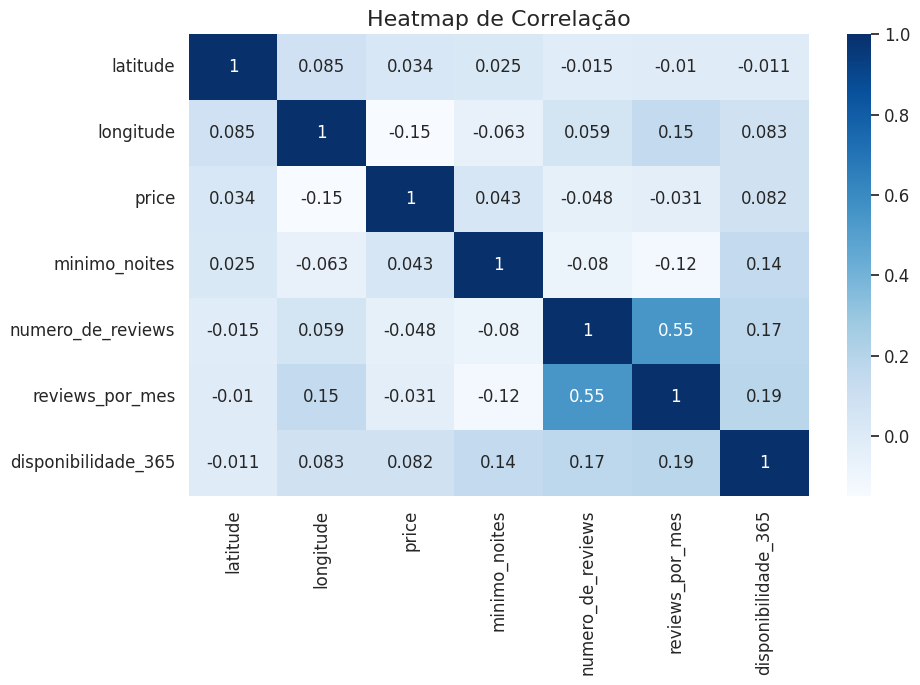

In [81]:
# Correlações numéricas
num_cols = ['latitude','longitude','price','minimo_noites','numero_de_reviews',
            'reviews_por_mes','disponibilidade_365']
corr = df[num_cols].corr()
print("\nMatriz de Correlação")
display(corr)

plt.figure()
sns.heatmap(corr, annot=True, cmap='Blues')
plt.title("Heatmap de Correlação")
plt.show()

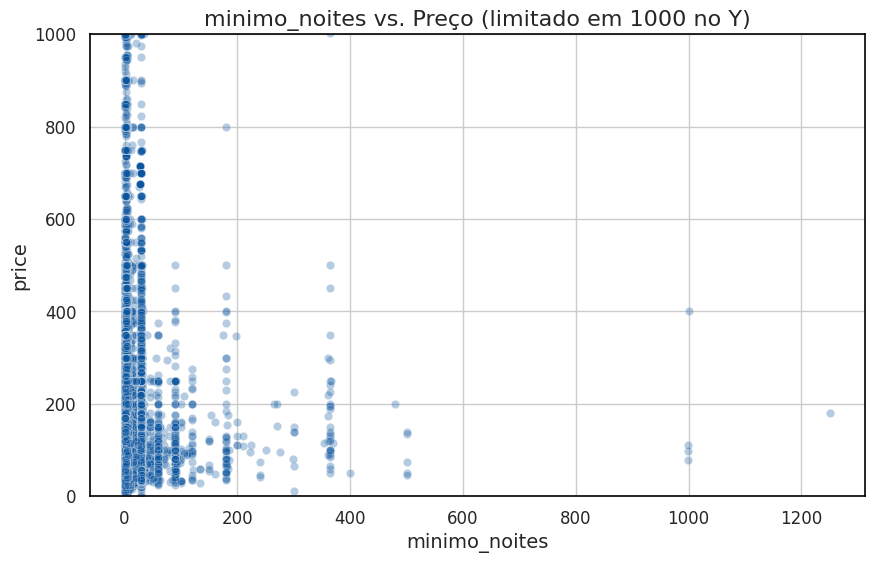

In [82]:
# Scatter plots: price vs minimo_noites
sns.scatterplot(data=df, x='minimo_noites', y='price', alpha=0.3)
plt.ylim(0, 1000)
plt.title("minimo_noites vs. Preço (limitado em 1000 no Y)")
plt.show()

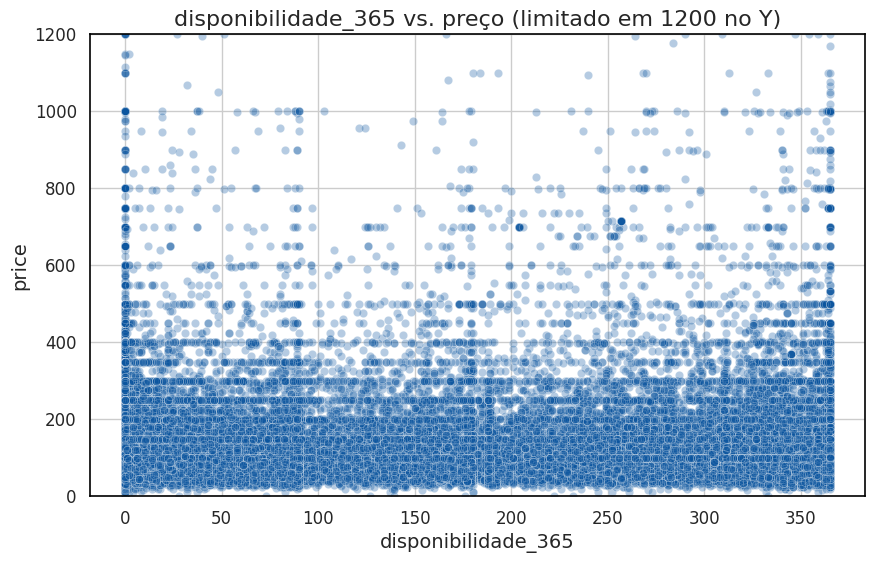

In [83]:
# price vs disponibilidade_365
sns.scatterplot(data=df, x='disponibilidade_365', y='price', alpha=0.3)
plt.ylim(0, 1200)
plt.title("disponibilidade_365 vs. preço (limitado em 1200 no Y)")
plt.show()


Correlação de `minimo_noites` com `price` é 0.043, fraco impacto.  



#### Visualização espacial

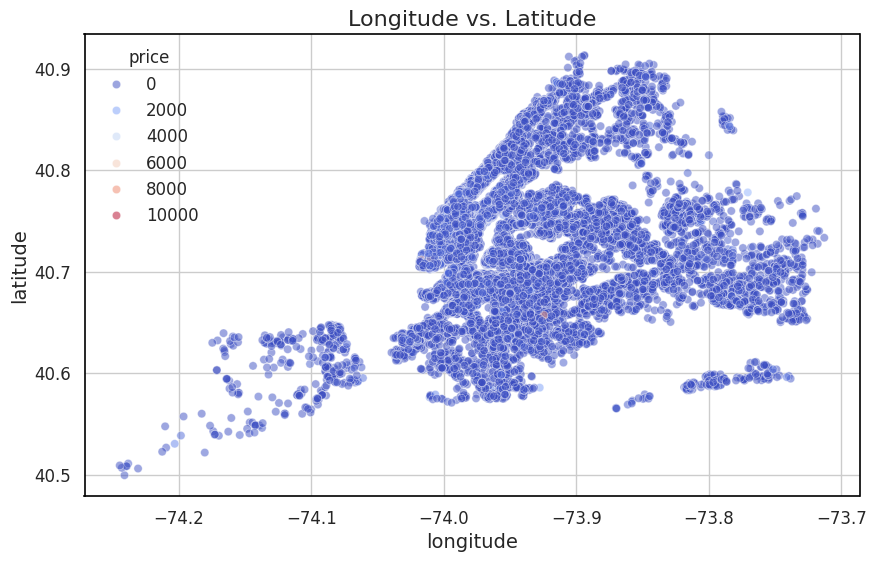

In [84]:
# latitude vs longitude, color por price
plt.figure()
sns.scatterplot(data=df, x='longitude', y='latitude',
                hue='price', palette='coolwarm', alpha=0.5)
plt.title("Longitude vs. Latitude")
plt.show()

## 4. **Preparação** (remoção outliers, dummies, etc)

In [85]:
def remover_outliers_iqr(df, coluna='preco', fator=1.5):
    """
    Remove outliers com base no IQR (faixa interquartil).
    Retorna (df_filtrado, qtd_removidos, pct_removido, (lim_inf, lim_sup)).
    """
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1

    lim_inferior = max(1, Q1 - fator * IQR)
    lim_superior = Q3 + fator * IQR

    n_antes = len(df)
    df_filtrado = df[(df[coluna] >= lim_inferior) & (df[coluna] <= lim_superior)]
    n_depois = len(df_filtrado)

    qtd_removidos = n_antes - n_depois
    pct_removido = 100.0 * qtd_removidos / n_antes
    return df_filtrado, qtd_removidos, pct_removido, (lim_inferior, lim_superior)

# Removendo colunas irrelevantes
colunas_remover = ['id','nome','host_name','ultima_review','host_id']
df.drop(columns=colunas_remover, inplace=True, errors='ignore')

# Preenchendo nulos em reviews_por_mes
df['reviews_por_mes'] = df['reviews_por_mes'].fillna(0)

# # Convertendo colunas categóricas
# for col in ['bairro_group','bairro','room_type']:
#     if col in df.columns:
#         df[col] = df[col].astype('category')

# Remoção de outliers no atributo price usando o método IQR
df_limpo, removidos, pct_removido, limites = remover_outliers_iqr(df, coluna='price', fator=1.5)
print(f"\n Removidos {removidos} registros ({pct_removido:.2f}%) via IQR=1.5 no 'price'.")
print(f"Intervalo final de price após IQR: [{limites[0]}, {limites[1]}]")



 Removidos 2983 registros (6.10%) via IQR=1.5 no 'price'.
Intervalo final de price após IQR: [1, 334.0]


## 3.4 Visualizações após remoção de outliers

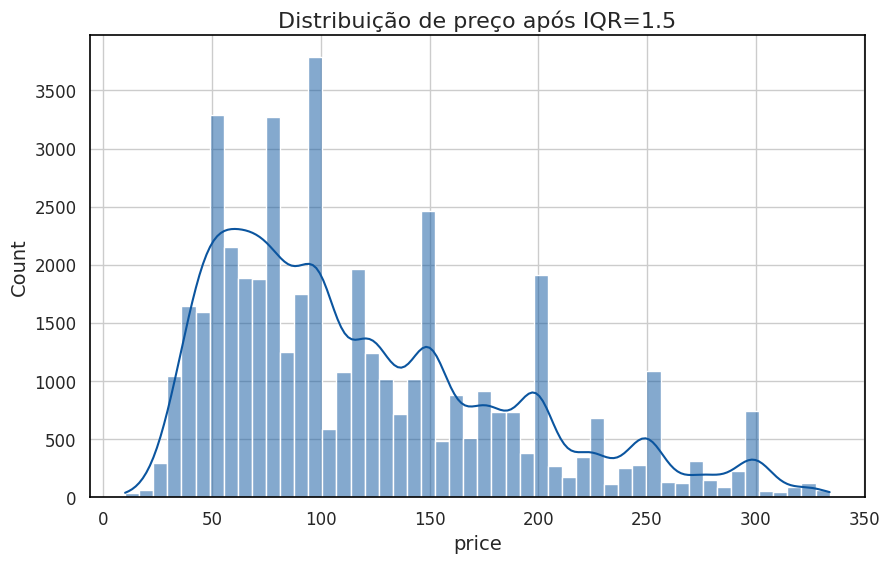

In [86]:
# preço após remoção
plt.figure()
sns.histplot(df_limpo['price'], bins=50, kde=True)
plt.title("Distribuição de preço após IQR=1.5")
plt.show()


In [87]:
# Novas estatísticas / após remoção
print("\nEstatísticas após IQR")
print(df_limpo.describe())



Estatísticas após IQR
           latitude     longitude         price  minimo_noites  \
count  45911.000000  45911.000000  45911.000000   45911.000000   
mean      40.728494    -73.950739    119.998432       6.938098   
std        0.055332      0.046473     68.133611      19.859702   
min       40.499790    -74.244420     10.000000       1.000000   
25%       40.689240    -73.981940     65.000000       1.000000   
50%       40.721780    -73.954370    100.000000       2.000000   
75%       40.763395    -73.934330    159.000000       5.000000   
max       40.913060    -73.712990    334.000000    1250.000000   

       numero_de_reviews  reviews_por_mes  calculado_host_listings_count  \
count       45911.000000     45911.000000                   45911.000000   
mean           23.940515         1.107645                       6.640282   
std            45.316661         1.612600                      31.012164   
min             0.000000         0.000000                       1.000000   
25

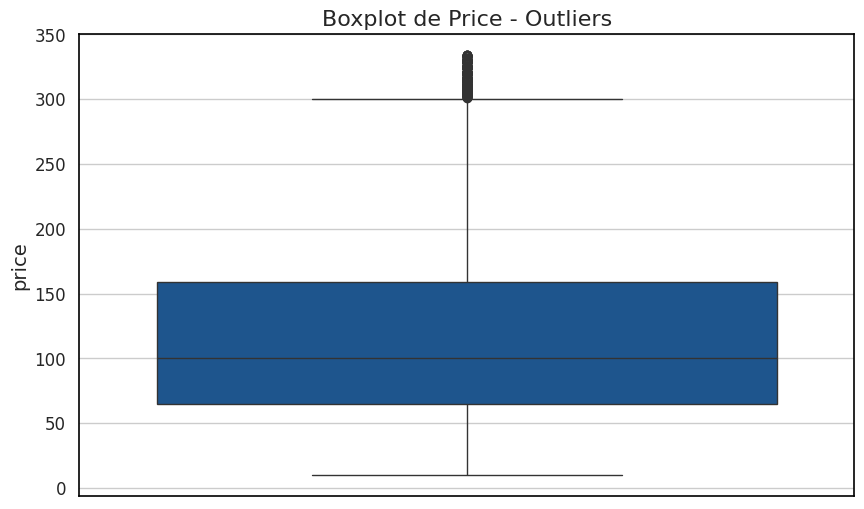

In [88]:
# Boxplot
plt.figure()
sns.boxplot(y=df_limpo['price'])
plt.title("Boxplot de Price - Outliers")
plt.show()

In [89]:
# Estatísticas focadas em Price
print("Estatísticas de price:\n", df_limpo['price'].describe())

Estatísticas de price:
 count    45911.000000
mean       119.998432
std         68.133611
min         10.000000
25%         65.000000
50%        100.000000
75%        159.000000
max        334.000000
Name: price, dtype: float64


### Agrupamentos

#### Agrupamento por bairros

In [90]:
print("bairro_group - Contagem:")
display(df_limpo['bairro_group'].value_counts())
plt.figure()

bairro_group - Contagem:


,count
bairro_group,
Manhattan,19505
Brooklyn,19405
Queens,5567
Bronx,1069
Staten Island,365


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

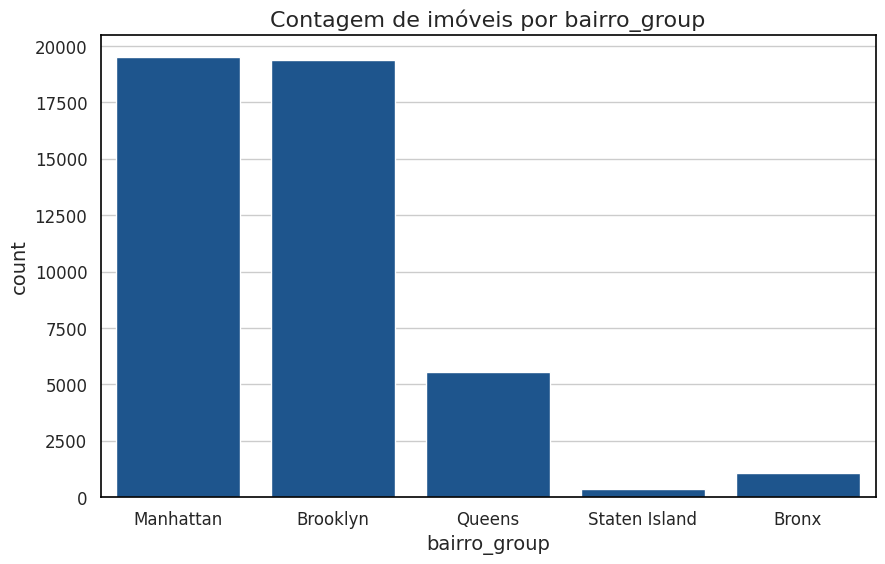

In [91]:
sns.countplot(x='bairro_group', data=df_limpo)
plt.title("Contagem de imóveis por bairro_group")
plt.show()


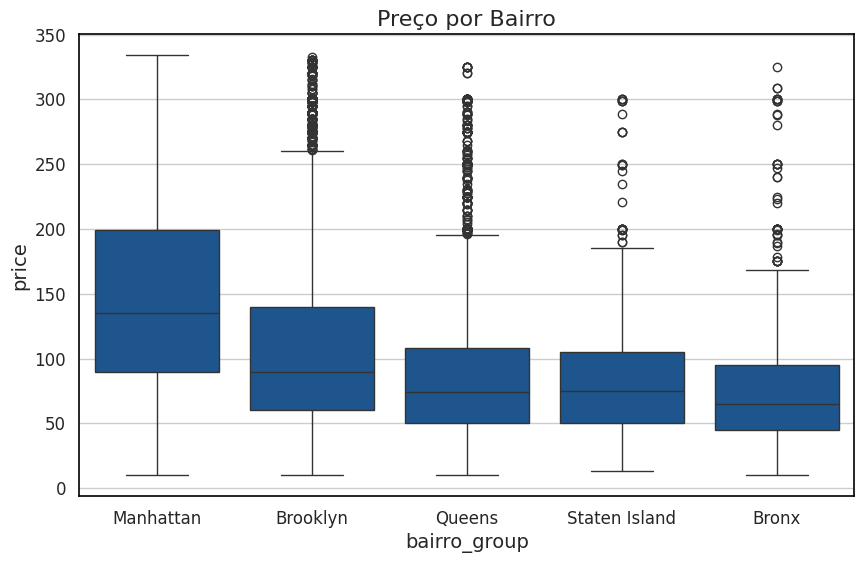

In [92]:
# Boxplot por 'bairro_group'
if 'bairro_group' in df_limpo.columns:
    plt.figure()
    sns.boxplot(data=df_limpo, x='bairro_group', y='price')
    plt.title("Preço por Bairro")
    plt.show()

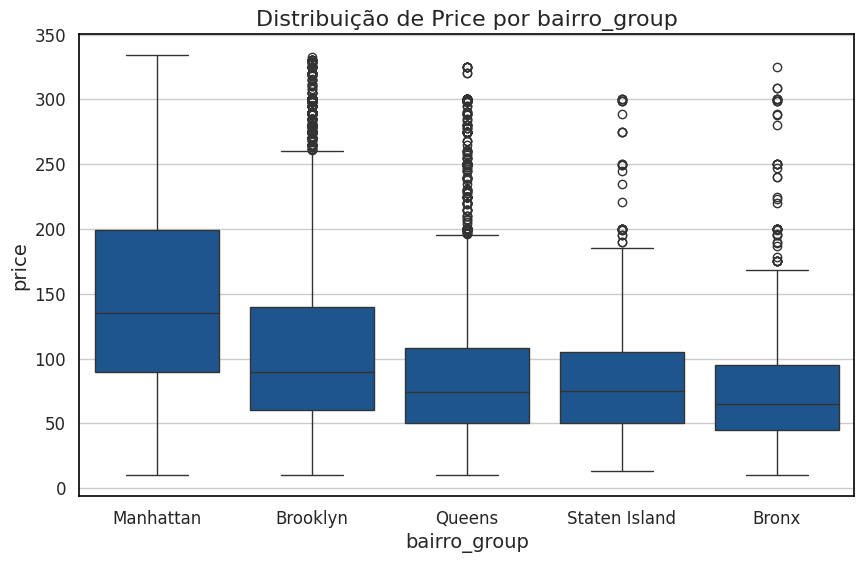

In [93]:
# Price vs. bairro_group
plt.figure()
sns.boxplot(x='bairro_group', y='price', data=df_limpo)
plt.title("Distribuição de Price por bairro_group")
plt.show()

### Tipo de quarto

In [94]:
print("\nTipo de Quarto - room_type - Contagem:")
display(df_limpo['room_type'].value_counts())
plt.figure()


Tipo de Quarto - room_type - Contagem:


,count
room_type,
Entire home/apt,22787
Private room,21988
Shared room,1136


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

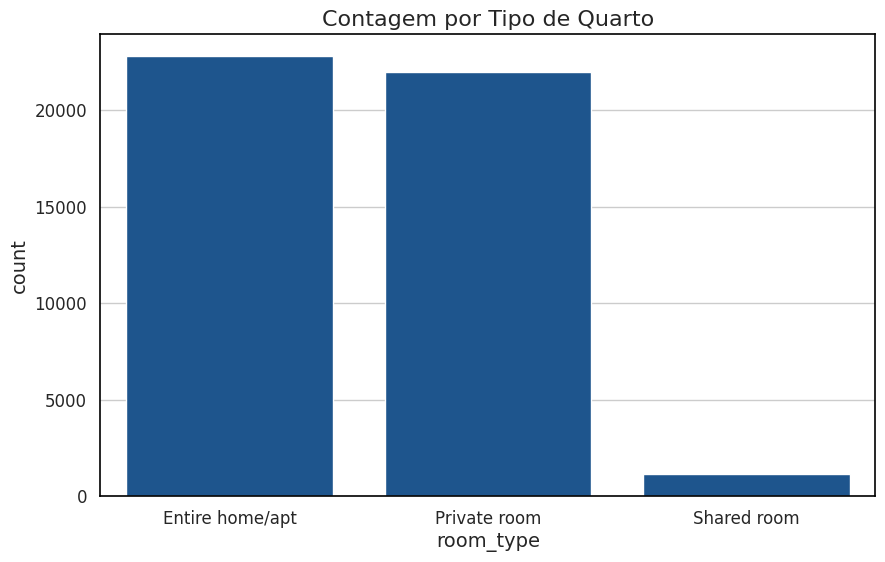

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [95]:
sns.countplot(x='room_type', data=df_limpo)
plt.title("Contagem por Tipo de Quarto")
plt.show()
plt.figure()

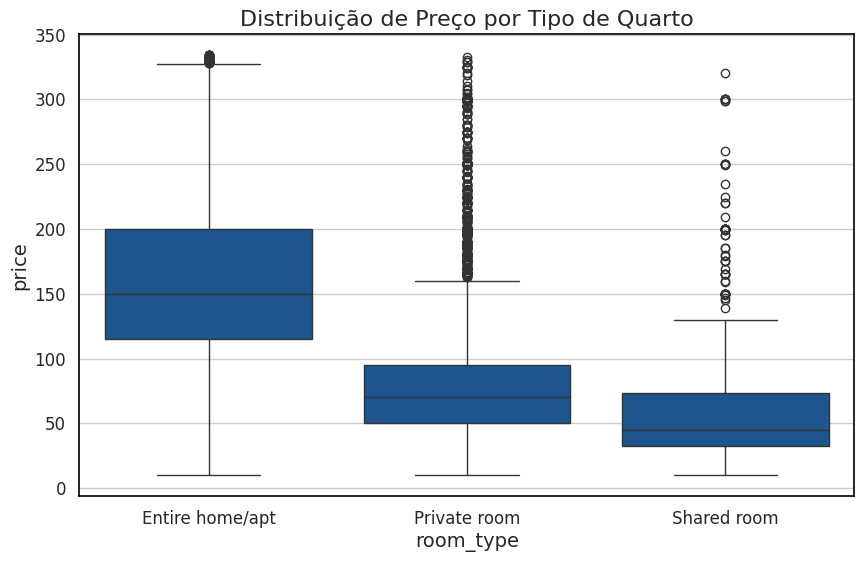

In [96]:
sns.boxplot(x='room_type', y='price', data=df_limpo)
plt.title("Distribuição de Preço por Tipo de Quarto")
plt.show()

**Possíveis Conclusões**:
1. `Entire home/apt` tende a ter **maior** mediana de preço.  
2. `Private room` e `Shared room` custam menos, mas também podem ter maior número de reviews (público que busca economia).

**Hipótese**:
- Investir em `Entire home/apt` em Manhattan para elevar o valor médio cobrado, muito embora o custo inicial seja provavelmente mais alto.

---


### Variaveis númericas


Matriz de Correlação


,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,disponibilidade_365
latitude,1.000000,0.091354,0.068762,0.025898,-0.012508,-0.017975,-0.017343
longitude,0.091354,1.000000,-0.306965,-0.064249,0.053791,0.140477,0.096987
price,0.068762,-0.306965,1.000000,0.031479,-0.027603,-0.047288,0.066655
minimo_noites,0.025898,-0.064249,0.031479,1.000000,-0.082862,-0.127771,0.146445
numero_de_reviews,-0.012508,0.053791,-0.027603,-0.082862,1.000000,0.593745,0.183582
reviews_por_mes,-0.017975,0.140477,-0.047288,-0.127771,0.593745,1.000000,0.171416
disponibilidade_365,-0.017343,0.096987,0.066655,0.146445,0.183582,0.171416,1.000000


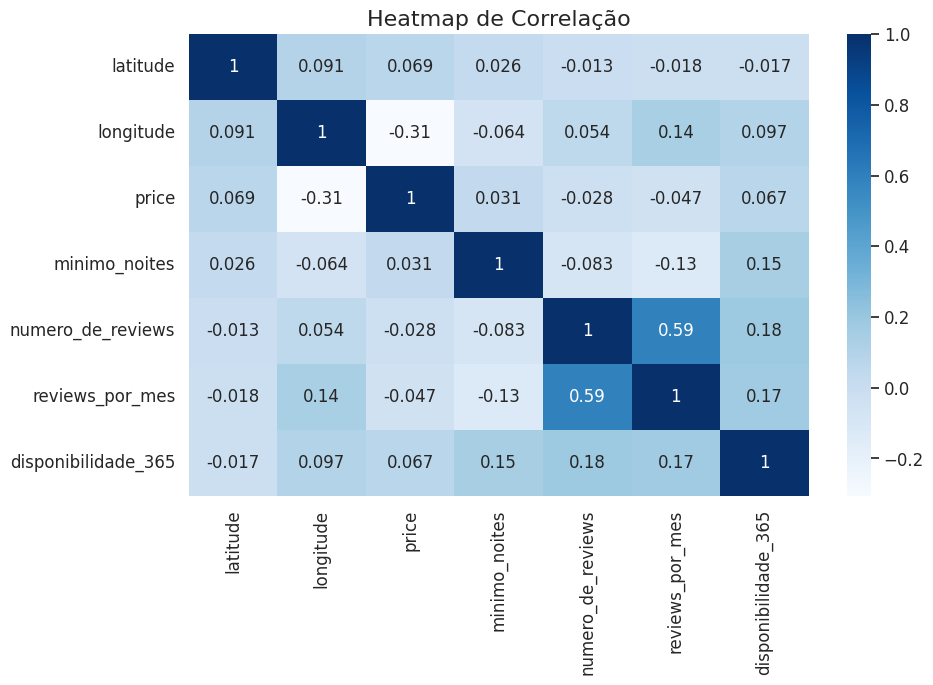

In [97]:
# Correlações numéricas
num_cols = ['latitude','longitude','price','minimo_noites','numero_de_reviews',
            'reviews_por_mes','disponibilidade_365']
corr = df_limpo[num_cols].corr()
print("\nMatriz de Correlação")
display(corr)

plt.figure()
sns.heatmap(corr, annot=True, cmap='Blues')
plt.title("Heatmap de Correlação")
plt.show()

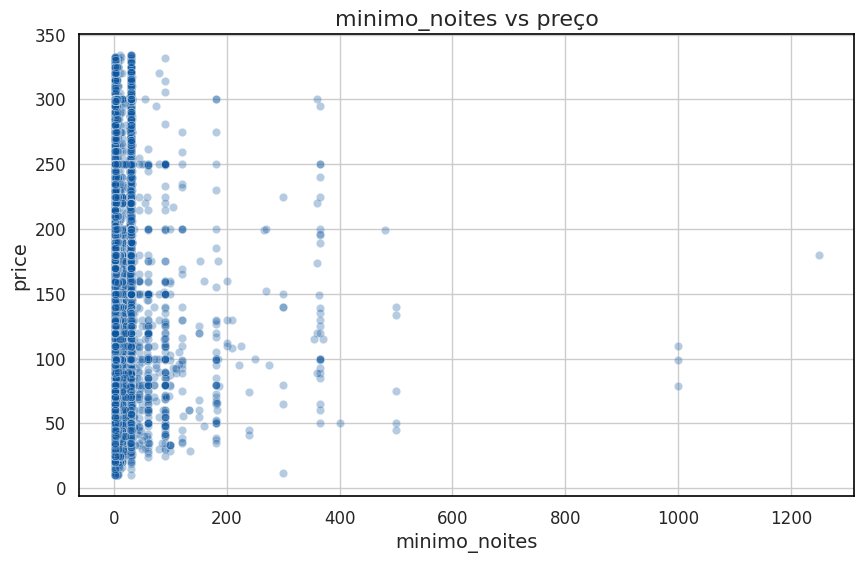

In [98]:
# Scatter plots: price vs minimo_noites
sns.scatterplot(data=df_limpo, x='minimo_noites', y='price', alpha=0.3)
plt.title("minimo_noites vs preço")
plt.show()

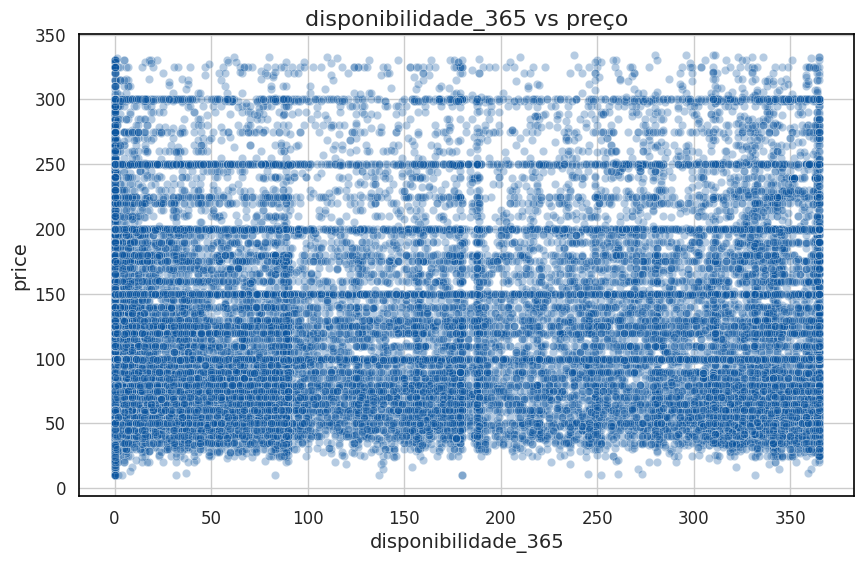

In [99]:
# price vs disponibilidade_365
sns.scatterplot(data=df_limpo, x='disponibilidade_365', y='price', alpha=0.3)
plt.title("disponibilidade_365 vs preço")
plt.show()

### Visualização espacial

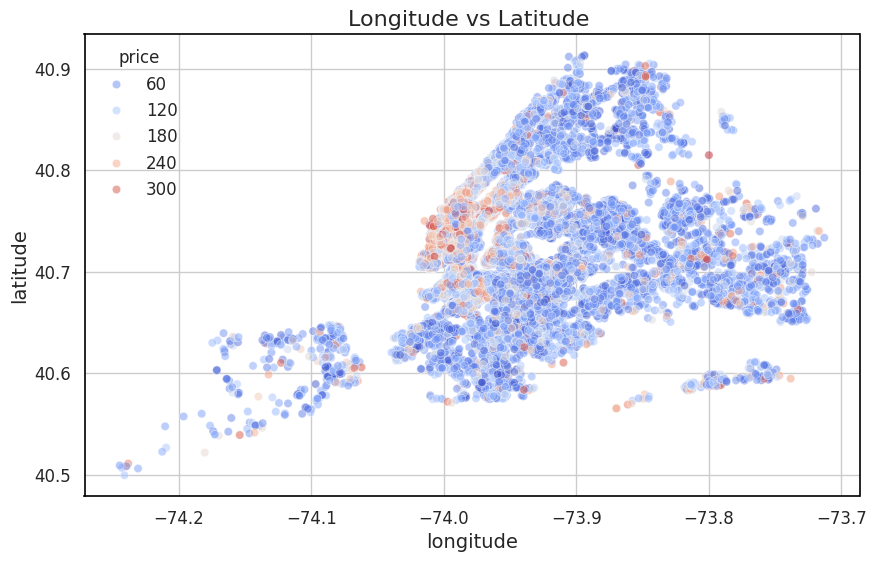

In [100]:
# latitude vs longitude, color por price
plt.figure()
sns.scatterplot(data=df_limpo, x='longitude', y='latitude',
                hue='price', palette='coolwarm', alpha=0.5)
plt.title("Longitude vs Latitude ")
plt.show()

**Comentário**:

- Visualmente, podemos ver a densidade de rpreços altos em Manhattan   


**Hipótese**:
- Latitude / longitude podem ter um impacto real no valor, com base no mapa de correlação também




Hipótese de negócio:

A variação dos preços em função da proximidade a pontos de interesse (Times Square, Central Park) sugere que o preço pode ser ajustado dinamicamente. Estratégias que considerem a localização e a demanda local podem maximizar a receita.

## 4. Transformações pré-treino

In [101]:
# Criar dummies e log_price
df_limpo = pd.get_dummies(df_limpo, columns=['bairro_group','bairro','room_type'], drop_first=True)
df_limpo['log_price'] = np.log1p(df_limpo['price'])


In [102]:
# remover caracteres especiais do nome das colunas
df_limpo.columns = df_limpo.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

## Treinamento de Modelos

In [103]:
def avaliar_modelo_com_split(modelo, X_treino, X_teste, y_treino, y_teste):
    """
    Treina o modelo utilizando X_treino e y_treino,
    realiza predições em X_teste e calcula as métricas comparando com y_teste.
    Considera que y está em escala logarítmica e faz a conversão para a escala original.
    Retorna: rmse, mae, r2 e o modelo treinado.
    """
    modelo.fit(X_treino, y_treino)
    y_pred_log = modelo.predict(X_teste)

    # Converter de log para o valor real
    y_teste_real = np.expm1(y_teste)
    y_pred_real = np.expm1(y_pred_log)

    rmse = np.sqrt(mean_squared_error(y_teste_real, y_pred_real))
    mae = mean_absolute_error(y_teste_real, y_pred_real)
    r2  = r2_score(y_teste_real, y_pred_real)

    return rmse, mae, r2, modelo

In [104]:

cenarios_resultados = {}
for usar_feat in [False, True]:
    # Cria variáveis adicionais de acordo com o cenário
    df_cenario = criar_variaveis_adicionais(df_limpo, usar_features=usar_feat)
    rotulo_cenario = "COM_FEATURES" if usar_feat else "SEM_FEATURES"
    print(f"\n===== Cenário: {rotulo_cenario} =====")

    # Realiza o split
    X = df_cenario.drop(columns=['price','log_price'], errors='ignore')
    y = df_cenario['log_price']
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)


    # Define os modelos a serem avaliados
    modelos_dict = {
        'ArvoreDecisao': DecisionTreeRegressor(random_state=42),
        'FlorestaRandomica': RandomForestRegressor(random_state=42),
        'GradientBoost': GradientBoostingRegressor(random_state=42),
        'Linear': LinearRegression(),
        'Ridge': Ridge(),
    }

    if xgboost_disponivel:
        from xgboost import XGBRegressor
        modelos_dict['XGBoost'] = XGBRegressor(random_state=42, tree_method='hist')

    if lightgbm_disponivel:
        from lightgbm import LGBMRegressor
        modelos_dict['LightGBM'] = LGBMRegressor(random_state=42)

    if catboost_disponivel:
        from catboost import CatBoostRegressor
        modelos_dict['CatBoost'] = CatBoostRegressor(random_state=42, verbose=False)

    cenario_res = {}
    for nome_mod, modelo in modelos_dict.items():
        rmse_val, mae_val, r2_val, mod_treinado = avaliar_modelo_com_split(modelo, X_treino, X_teste, y_treino, y_teste)
        cenario_res[nome_mod] = {
            'RMSE': rmse_val,
            'MAE': mae_val,
            'R2': r2_val,
            'modelo': mod_treinado,
        }
        print(f"[{nome_mod}] -> RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R²: {r2_val:.4f}")

    cenarios_resultados[rotulo_cenario] = cenario_res
    print("-" * 60)
# Selecionar o melhor modelo
melhor_modelo = None
melhor_nome = None
melhor_rmse = float('inf')

for cenario in ["SEM_FEATURES", "COM_FEATURES"]:
    for mod_n, dic_met in cenarios_resultados[cenario].items():
        if dic_met['RMSE'] < melhor_rmse:
            melhor_rmse = dic_met['RMSE']
            melhor_modelo = dic_met['modelo']
            melhor_nome = mod_n

print(f"\n=== Melhor modelo: {melhor_nome} (RMSE={melhor_rmse:.4f}) ===")
salvar_modelo(melhor_modelo, "melhor_modelo.pkl")


===== Cenário: SEM_FEATURES =====
[ArvoreDecisao] -> RMSE: 60.5835, MAE: 42.2335, R²: 0.1939
[FlorestaRandomica] -> RMSE: 44.6484, MAE: 30.8203, R²: 0.5622
[GradientBoost] -> RMSE: 45.8308, MAE: 31.8536, R²: 0.5387
[Linear] -> RMSE: 47.5134, MAE: 33.2447, R²: 0.5042
[Ridge] -> RMSE: 47.5131, MAE: 33.2238, R²: 0.5042
[XGBoost] -> RMSE: 44.5302, MAE: 30.9038, R²: 0.5645
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1630
[LightGBM] [Info] Number of data points in the train set: 36728, number of used features: 135
[LightGBM] [Info] Start training from score 4.637799
[LightGBM] -> RMSE: 44.7095, MAE: 30.9333, R²: 0.5610
[CatBoost] -> RMSE: 44.4002, MAE: 30.7311, R²: 0.5671
------------------------------------------------------------

===== Cenário: COM_FEATURES =====
[ArvoreDecisao] -> RMSE: 62.0413, MAE: 43.2963, R²: 0.1547
[FlorestaRandomica] ->

In [105]:
# Sumário final
print("\n=== SUMÁRIO DE RESULTADOS (RMSE, MAE, R²) ===")
for rotulo_cenario, dics_modelos in cenarios_resultados.items():
    print(f"\n--- {rotulo_cenario} ---")
    for n_mod, met in dics_modelos.items():
        print(f"{n_mod}: RMSE={met['RMSE']:.2f}, MAE={met['MAE']:.2f}, R²={met['R2']:.2f}")



=== SUMÁRIO DE RESULTADOS (RMSE, MAE, R²) ===

--- SEM_FEATURES ---
ArvoreDecisao: RMSE=60.58, MAE=42.23, R²=0.19
FlorestaRandomica: RMSE=44.65, MAE=30.82, R²=0.56
GradientBoost: RMSE=45.83, MAE=31.85, R²=0.54
Linear: RMSE=47.51, MAE=33.24, R²=0.50
Ridge: RMSE=47.51, MAE=33.22, R²=0.50
XGBoost: RMSE=44.53, MAE=30.90, R²=0.56
LightGBM: RMSE=44.71, MAE=30.93, R²=0.56
CatBoost: RMSE=44.40, MAE=30.73, R²=0.57

--- COM_FEATURES ---
ArvoreDecisao: RMSE=62.04, MAE=43.30, R²=0.15
FlorestaRandomica: RMSE=44.76, MAE=30.98, R²=0.56
GradientBoost: RMSE=45.66, MAE=31.77, R²=0.54
Linear: RMSE=47.45, MAE=33.18, R²=0.51
Ridge: RMSE=47.45, MAE=33.17, R²=0.51
XGBoost: RMSE=44.69, MAE=30.99, R²=0.56
LightGBM: RMSE=44.64, MAE=30.92, R²=0.56
CatBoost: RMSE=44.31, MAE=30.65, R²=0.57


In [106]:
# Seleção e analise do melhor modelo:
if melhor_nome == 'CatBoost':
    print("\nAnálise do Modelo CatBoost ")

    # O modelo foi treinado com y em log, portanto convertemos as predições de volta para o preço original
    y_pred_log = melhor_modelo.predict(X_teste)
    y_pred = np.expm1(y_pred_log)         # Converte as predições para a escala original
    y_test_real = np.expm1(y_teste)         # Converte os valores reais

    # Métricas
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    rmse_final = np.sqrt(mean_squared_error(y_test_real, y_pred))
    mae_final = mean_absolute_error(y_test_real, y_pred)
    r2_final = r2_score(y_test_real, y_pred)

    print("\nAvaliação Final do Modelo CatBoost")
    print(f"RMSE: {rmse_final:.4f}")
    print(f"MAE:  {mae_final:.4f}")
    print(f"R²:   {r2_final:.4f}")



Análise do Modelo CatBoost 

Avaliação Final do Modelo CatBoost
RMSE: 44.3135
MAE:  30.6498
R²:   0.5687


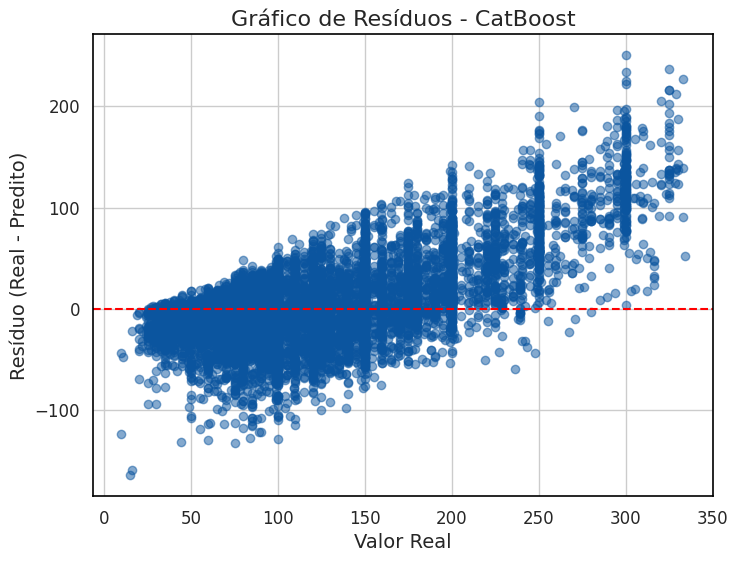

In [107]:

    # Gráfico de Resíduos
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_real, y_test_real - y_pred, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Valor Real")
    plt.ylabel("Resíduo (Real - Predito)")
    plt.title("Gráfico de Resíduos - CatBoost")
    plt.show()


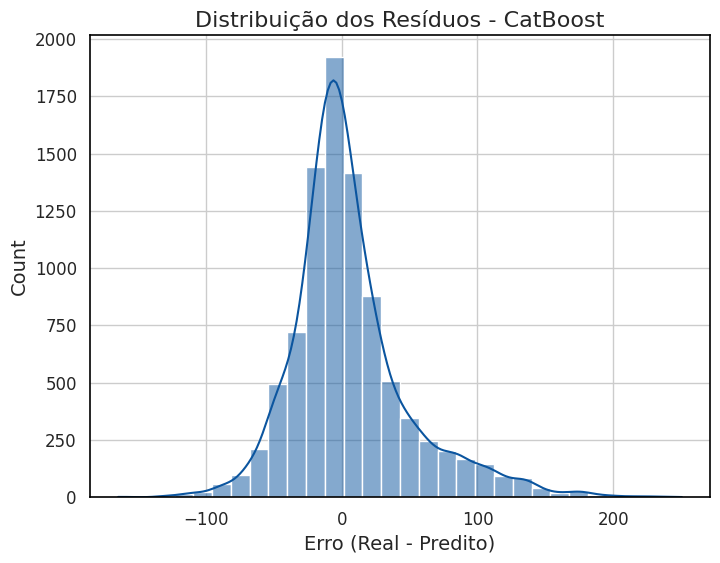

In [108]:
    # Distribuição dos Erros
    erro = y_test_real - y_pred
    plt.figure(figsize=(8, 6))
    sns.histplot(erro, bins=30, kde=True)
    plt.title("Distribuição dos Resíduos - CatBoost")
    plt.xlabel("Erro (Real - Predito)")
    plt.show()



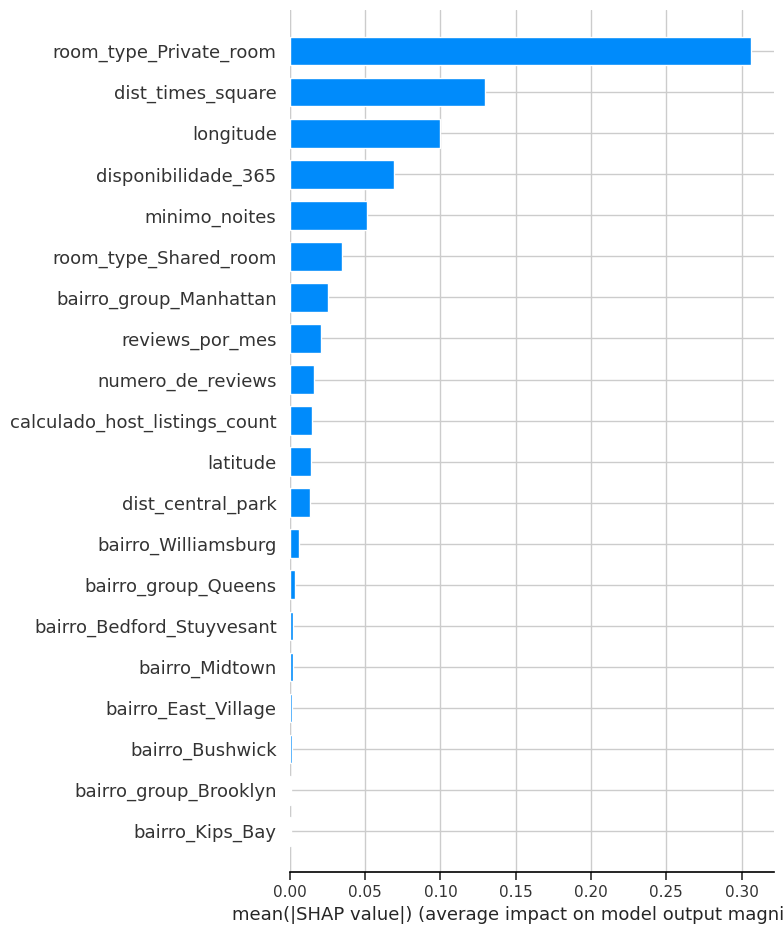

In [109]:
    # Cria o explicador utilizando o modelo treinado
    explainer = shap.TreeExplainer(melhor_modelo)
    shap_values = explainer.shap_values(X_teste)

    # Summary plot em formato de barras
    shap.summary_plot(shap_values, X_teste, plot_type="bar", show=True)


## Exemplo de Previsão

In [110]:
novo_apt = {
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}

# Gerar dataframe de 1 linha
test_df = pd.DataFrame([novo_apt])
# Converter colunas categóricas
for c in ['bairro_group','bairro','room_type']:
    if c in test_df.columns:
        test_df[c] = test_df[c].astype('category')

# Precisamos ter as mesmas colunas do df_clean (exceto log_price).
full_cols = df_limpo.drop(columns=['log_price','price'], errors='ignore').columns
test_df = pd.get_dummies(test_df, columns=['bairro_group','bairro','room_type'], drop_first=True)

# # Adicionar colunas ausentes, se necessário
# for col in full_cols:
#     if col not in test_df.columns:
#         test_df[col] = 0

# # Reordenar colunas
# test_df = test_df[full_cols]

# Reindexar o DataFrame para ter todas as colunas necessárias, preenchendo com 0 onde estiverem ausentes
test_df = test_df.reindex(columns=full_cols, fill_value=0)

# Se for COM_FEATURES, criamos as colunas extras
test_df_feat = criar_variaveis_adicionais(test_df, usar_features=True)

# Carrega o best_model salvo
loaded_model = joblib.load("melhor_modelo.pkl")

# Faz a previsão
y_pred_log = loaded_model.predict(test_df_feat)
price_pred = np.expm1(y_pred_log)
print(f"\n>>> Previsão de preço para {novo_apt}: \n US$ {price_pred[0]:.2f}")

print("\n=== finalizado! ===")


>>> Previsão de preço para {'bairro_group': 'Manhattan', 'bairro': 'Midtown', 'latitude': 40.75362, 'longitude': -73.98377, 'room_type': 'Entire home/apt', 'minimo_noites': 1, 'numero_de_reviews': 45, 'reviews_por_mes': 0.38, 'calculado_host_listings_count': 2, 'disponibilidade_365': 355}: 
 US$ 195.35

=== finalizado! ===


#Perguntas:

### a) Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?


Manhattan apresenta os maiores preços médios, porém fica perto dos ponto turísticos


Brooklyn tem preços intermediários e pode oferecer um bom custo-benefício para investimento.


Bairros como Queens e Bronx possuem valores baixos e um provável preço de aquisição menor, quando comparado com Manhattan, porém são mais afastados dos pontos turísticos, fato que pode afastar os turistas.

![image.png](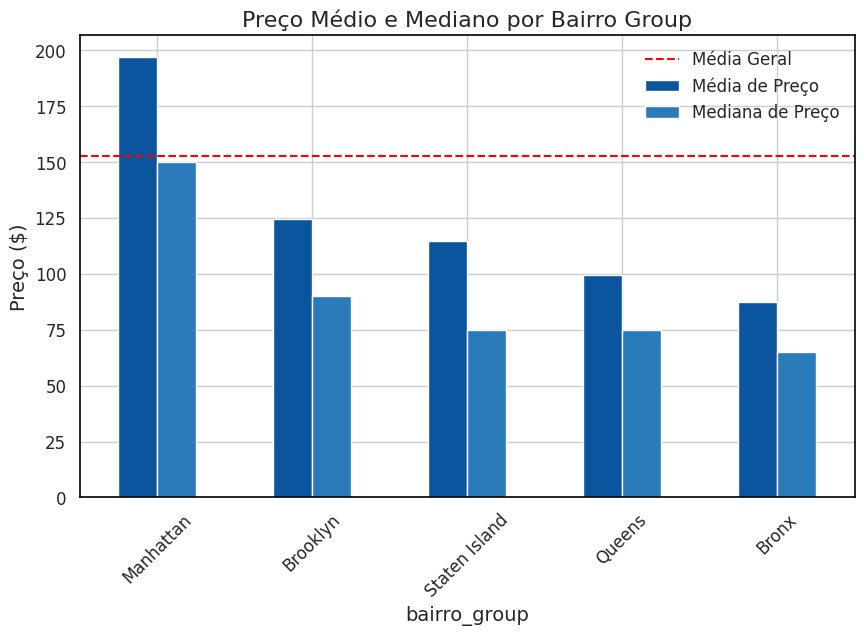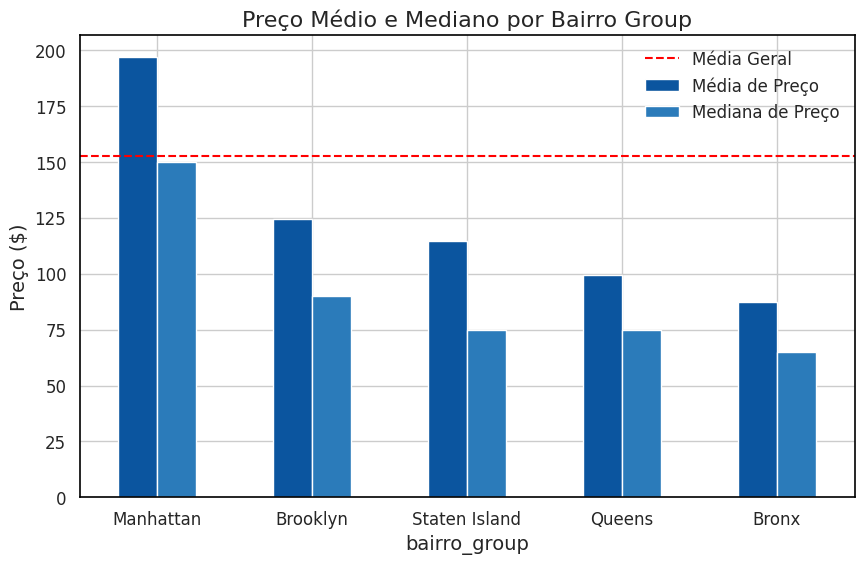)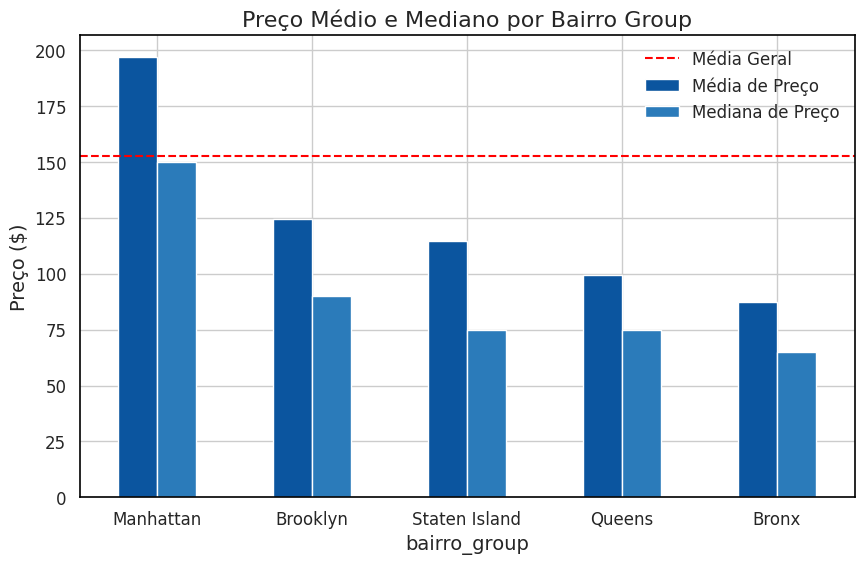

### b) O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?


Por mais que o mapa de correlação tenha indicado a correlação entre minimo_noites e price muito baixa (0.031), indicando que o impacto é insignificante e a disponibilidade (disponibilidade_365) que também tem correlação fraca (0.067).
E que no scatterplot de minimo_noites vs price, vemos que a maioria dos imóveis permite poucas noites, sem relação clara com preços.

No treinamento do modelo essas variavéis estavam entre as top 5 mais importantes, com a disponibilidade em quarto lugar. Isso indica que elas não tem uma relação linear forte com o preço mas são importantes para determinar o preço final.

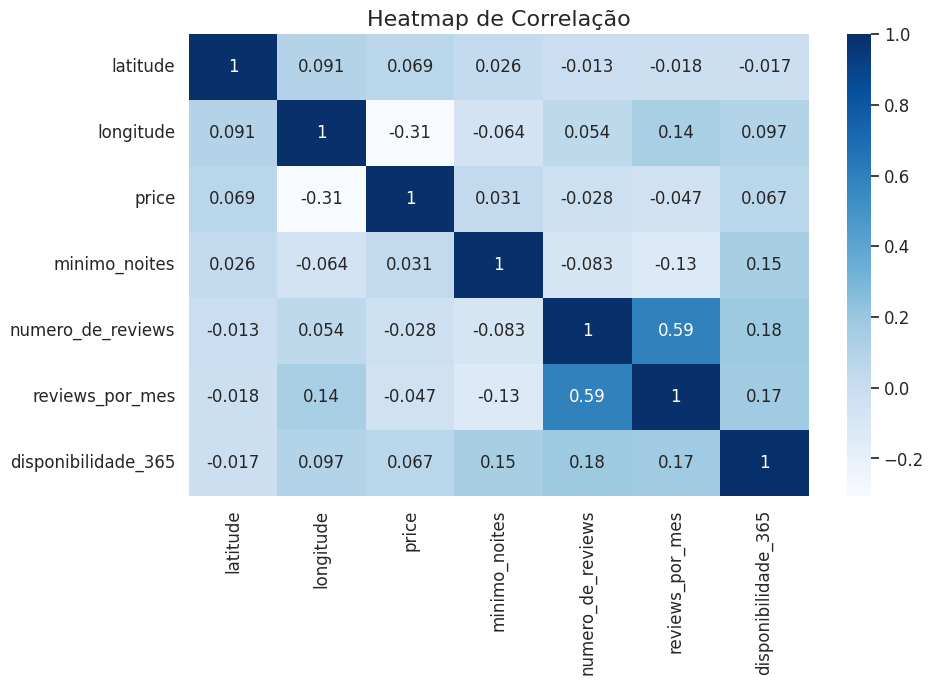

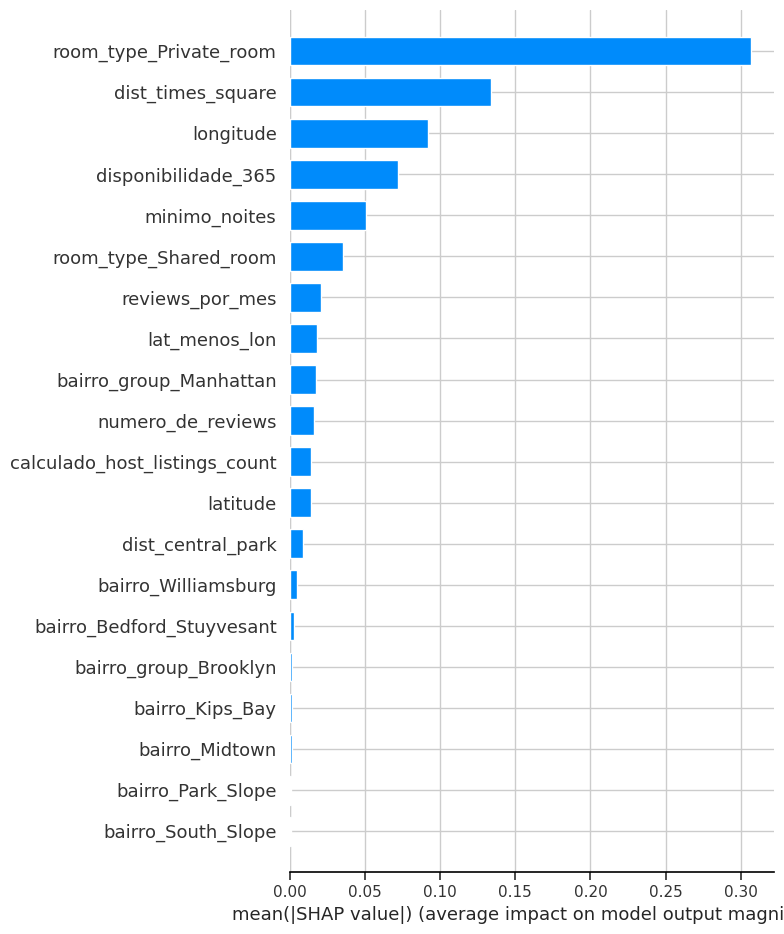

### c) Padrão de palavras imoveis alto valor

In [111]:
df_nome = pd.read_csv("teste_indicium_precificacao.csv")
df_nome.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842.000000,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,1.373251,7.144005,112.776169
std,1.098288e+07,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,1.680453,32.952855,131.618692
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [112]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words_en = set(stopwords.words('english'))

def preprocess_text(text):
    # Convertendo udo para minúsculo
    text = text.lower()
    # Removendo pontuação e caracteres especiais, mantem letras e espaços
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenização
    tokens = text.split()
    # Removendo stopwords
    tokens = [token for token in tokens if token not in stop_words_en]
    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [113]:
limite_high = df_nome['price'].quantile(0.85)
df_high = df_nome[df_nome['price'] >= limite_high]
df_low = df_nome[df_nome['price'] < limite_high]


In [114]:
from collections import Counter

def count_words(df_subset):
    all_tokens = []
    for name in df_subset['nome'].dropna():
        tokens = preprocess_text(name)
        all_tokens.extend(tokens)
    return Counter(all_tokens)

counter_high = count_words(df_high)
counter_low = count_words(df_low)

print("Palavras mais comuns em imóveis de alto valor:")
print(counter_high.most_common(10))

print("Palavras mais comuns em imóveis de baixo valor:")
print(counter_low.most_common(10))


Palavras mais comuns em imóveis de alto valor:
[('br', 1199), ('bedroom', 1171), ('apartment', 962), ('apt', 822), ('luxury', 664), ('village', 628), ('loft', 606), ('park', 538), ('east', 523), ('spacious', 501)]
Palavras mais comuns em imóveis de baixo valor:
[('room', 9937), ('bedroom', 6872), ('private', 6783), ('apartment', 5746), ('cozy', 4738), ('apt', 3812), ('brooklyn', 3695), ('studio', 3579), ('spacious', 3228), ('manhattan', 2965)]


In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Cria uma listas de nomes para cada grupo
names_high = df_high['nome'].dropna().tolist()
names_low = df_low['nome'].dropna().tolist()
names_total = names_high + names_low

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    token_pattern=r'\b[a-z]{2,}\b'
)
tfidf_matrix = vectorizer.fit_transform(names_total)
feature_names = np.array(vectorizer.get_feature_names_out())

# Separa a matriz para cada grupo
tfidf_high = tfidf_matrix[:len(names_high)]
tfidf_low = tfidf_matrix[len(names_high):]

# Calcula a média do TF-IDF para cada palavra nos dois grupos
mean_tfidf_high = np.mean(tfidf_high.toarray(), axis=0)
mean_tfidf_low = np.mean(tfidf_low.toarray(), axis=0)

diff = mean_tfidf_high - mean_tfidf_low
indices_ordered = np.argsort(diff)[::-1]

print("Palavras que mais diferenciam imóveis de alto valor:")
for i in indices_ordered[:10]:
    print(f"{feature_names[i]}: TF-IDF High = {mean_tfidf_high[i]:.4f} vs Low = {mean_tfidf_low[i]:.4f}")


Palavras que mais diferenciam imóveis de alto valor:
luxury: TF-IDF High = 0.0337 vs Low = 0.0100
loft: TF-IDF High = 0.0298 vs Low = 0.0138
village: TF-IDF High = 0.0327 vs Low = 0.0169
duplex: TF-IDF High = 0.0200 vs Low = 0.0058
west: TF-IDF High = 0.0250 vs Low = 0.0119
chelsea: TF-IDF High = 0.0182 vs Low = 0.0053
midtown: TF-IDF High = 0.0218 vs Low = 0.0095
blueground: TF-IDF High = 0.0113 vs Low = 0.0001
gym: TF-IDF High = 0.0131 vs Low = 0.0020
townhouse: TF-IDF High = 0.0140 vs Low = 0.0035


Sim, existe um padrão claro no nome do local.

 'luxury', 'loft', 'village' estão associados a valores mais altos, quando comparados com locais com preços mais baratos.
 acredito que seja interessante para o branding do anúncio.

## 3)Explique como você faria a previsão do preço a partir dos dados. -- Preparação dos Dados e Transformações

a) Coleta e Limpeza Inicial

Eu começo importando os dados de um arquivo CSV e faço uma análise exploratória (EDA) para entender as dimensões, tipos e estatísticas dos dados. Nessa etapa, identifico que há valores ausentes em algumas colunas (como reviews_por_mes) e que os preços variam bastante (com alguns valores extremos, conforme observado nos boxplots e histogramas).

b) Remoção de Outliers

Utilizo a função remover_outliers_iqr para filtrar os registros do preço com base no método IQR (faixa interquartil). Essa etapa é importante para evitar que outliers distorçam o treinamento dos modelos.

c) Transformação do Preço

Percebi que os preços têm uma distribuição assimétrica e com cauda longa. Para estabilizar a variância e melhorar as correlações, crio uma nova variável chamada log_price por meio da transformação logarítmica (especificamente, usando np.log1p(price)). Isso facilita o trabalho dos modelos de regressão, pois os resíduos tendem a ficar mais bem distribuídos.

d) Criação de Variáveis Adicionais

Utilizo a função criar_variaveis_adicionais para, quando necessário, gerar novas features (como a distância até a Times Square e ao Central Park, e a diferença entre latitude e longitude). Faço isso em dois cenários:

SEM_FEATURES: Sem as novas variáveis,
COM_FEATURES: Com as variáveis adicionais.
Isso me permite testar se essas novas informações podem melhorar a performance dos modelos.

e) Preparação das Features

Depois, removo colunas irrelevantes (como id, nome, host_name, etc.) e aplico one-hot encoding às variáveis categóricas (como bairro_group, bairro e room_type). Dessa forma, o modelo pode processar essas informações adequadamente.


Abordagem:
Depois de preparar os dados, eu divido o dataset em conjuntos de treinamento e teste (usando train_test_split com um random_state fixo para garantir reprodutibilidade). Assim, todos os modelos serão treinados e testados nos mesmos dados, permitindo uma comparação justa.

## 3.1) Tipo de problema?


Regressão (previsão de valor numérico)

## 3.2) Medida de performance?

Usei as métricas de RMSE, MAE, R² pois:

- RMSE penaliza erros grandes,ajudando a identificar modelos que possam estar cometendo desvios muito grandes.

- MAE mostra erro médio absoluto (que é mais interpretável)

- R² indica quanta variação do preço é explicada pelo modelo.

- Além disso, utilizei a métrica Feature Importance para avaliar os atributos mais relevantes para a decisão final do modelo.



## 4. Seleção do Melhor Modelo
Ao final do processo, comparei os resultados dos modelos para dois cenários (SEM_FEATURES e COM_FEATURES). Pela saída, observei que o modelo CatBoost apresentou o menor RMSE (44.4002), tanto no cenário sem quanto com features adicionais. Isso indica que o CatBoost se ajustou melhor aos dados.

Prós do CatBoost:

Alto Desempenho: O CatBoost apresenta uma performance superior a outros modelos de árvore testados.

Tratamento Eficiente de Variáveis Categóricas: Ele lida automaticamente com variáveis categóricas, o que é uma grande vantagem.

Robustez: Geralmente, ele é robusto a outliers e às variações dos dados.

Contras do CatBoost:

Complexidade Computacional: Pode ser mais pesado computacionalmente quando comparado a modelos mais simples, como a regressão linear.

Interpretação: A interpretação dos resultados pode ser um pouco mais complexa.